In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [28]:
from torch.autograd import Variable
train_x = Variable(torch.linspace(0, 1, 11))
train_y = Variable(torch.sin(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2)

In [29]:
from gpytorch.kernels import RBFKernel
from gpytorch.math.modules import Bias, Identity
from gpytorch.distributions import GPDistribution
from gpytorch.distributions.likelihoods import GaussianLikelihood

In [30]:
prior = GPDistribution(mean_module=Bias(), covar_module=RBFKernel())
likelihood = GaussianLikelihood()
prior.covar_module.initialize(log_lengthscale=-3)
prior.mean_module.initialize(bias=0)
likelihood.initialize(log_noise=math.log(0.09))

GaussianLikelihood (
)

In [31]:
def plot_model_and_predictions(latent_distribution, likelihood):
    f, (latent_ax, observed_ax) = plt.subplots(1, 2, figsize=(8, 3))
    
    test_x = Variable(torch.linspace(0, 1, 51))
    latent_pred = latent_distribution(test_x)
    observed_pred = likelihood(latent_pred)

    def ax_plot(ax, rand_var, title):
        lower, upper = rand_var.confidence_region()
        ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
        ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
        ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title(title)
    
    ax_plot(latent_ax, latent_pred, 'Latent Values (Function)')
    ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')
    
    return f

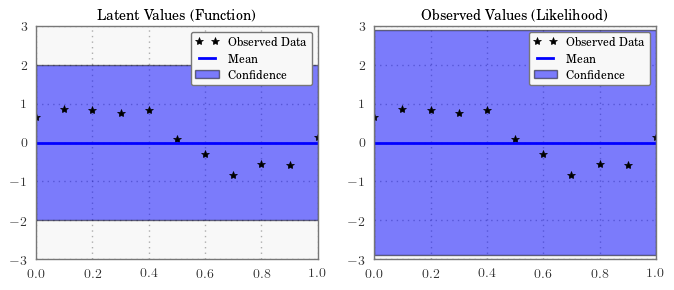

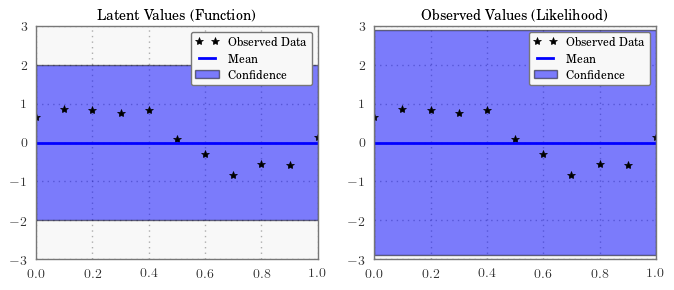

In [32]:
plot_model_and_predictions(prior, likelihood)

In [33]:
from gpytorch.inference import ExactGPInference

def log_function(loss, optimizer, latent_distribution, likelihood):
    return 'Iter: %02d, Loss: %.3f' % (optimizer.n_iter, loss.data[0])

infer = ExactGPInference(likelihood)
posterior_latent_distribution = infer.run(prior, train_x, train_y, log_function=log_function)

INFO:root:Iter: 01, Loss: 7.488
INFO:root:Iter: 02, Loss: 7.488
INFO:root:Iter: 03, Loss: 10.687
INFO:root:Iter: 04, Loss: 4.265
INFO:root:Iter: 05, Loss: 4.265
INFO:root:Iter: 06, Loss: 4.265
INFO:root:Iter: 07, Loss: 6.479
INFO:root:Iter: 08, Loss: 4.115
INFO:root:Iter: 09, Loss: 4.115
INFO:root:Iter: 10, Loss: 4.115
INFO:root:Iter: 11, Loss: 3.955
INFO:root:Iter: 12, Loss: 3.955
INFO:root:Iter: 13, Loss: 3.955
INFO:root:Iter: 14, Loss: 3.934
INFO:root:Iter: 15, Loss: 3.934
INFO:root:Iter: 16, Loss: 3.934
INFO:root:Iter: 17, Loss: 3.932
INFO:root:Iter: 18, Loss: 3.932
INFO:root:Iter: 19, Loss: 3.932
INFO:root:Iter: 20, Loss: 3.932
INFO:root:Iter: 21, Loss: 3.932
INFO:root:Iter: 22, Loss: 3.932
INFO:root:Iter: 23, Loss: 3.932
INFO:root:Iter: 24, Loss: 3.932
INFO:root:Iter: 25, Loss: 3.932
INFO:root:Iter: 26, Loss: 3.932
INFO:root:Iter: 27, Loss: 3.932
INFO:root:Iter: 28, Loss: 3.932
INFO:root:Iter: 29, Loss: 3.932
INFO:root:Iter: 30, Loss: 3.932
INFO:root:Iter: 31, Loss: 3.932
INFO:ro

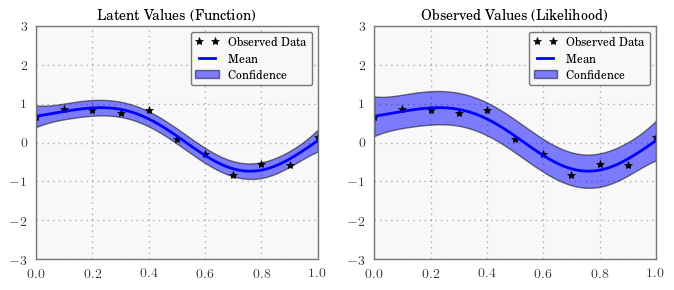

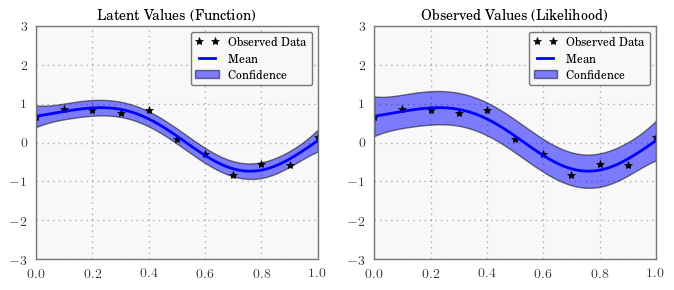

In [34]:
plot_model_and_predictions(posterior_latent_distribution, likelihood)